In [1]:
from Functions import *
from Optimizations import *
from Saving import *
import numpy as np
from scipy import stats
from Kernels import *
from utils import *

In [11]:
def create_animation_interactive_diffusion(particles_paths, second_path):
    """
    Assume all paths have same length. And that the length of first and second path are off by an integer factor."""
    if not os.path.isdir("./tmp"):
        os.mkdir("./tmp")
    ani_path = "./tmp/interactive_{}".format(time.time())
    os.mkdir(ani_path)
    
    trail_length = 20
    
    ratio = (particles_paths.shape[1] - 1) / (second_path.shape[0] - 1)
    assert int(ratio) == ratio

    for i in range(len(particles_paths[0])):
        X = particles_paths[:, i, 0].T
        Y = particles_paths[:, i, 1].T
        
            
        kernel = stats.gaussian_kde(np.vstack([X, Y]))
        trail_start = int(max(0, i/ratio - trail_length))
        trail_end = int(max(0, i/ratio + 1))
        x_min, x_max = -10, 10 #max(-15, min(min(X), min(second_path[trail_start:trail_end, 0]))), min(15, max(max(X), max(second_path[trail_start:trail_end, 0])))
        y_min, y_max = -10, 10 #max(-15, min(min(Y), min(second_path[trail_start:trail_end, 1]))), min(15, max(max(Y), max(second_path[trail_start:trail_end, 1])))
        
        positions = np.mgrid[x_min:x_max:0.2, y_min:y_max:0.2]
        
        Z = np.reshape(kernel(np.vstack([positions[0].ravel(), positions[1].ravel()])).T, positions[0].shape)

        fig, ax = plt.subplots()
        ax.imshow(Z, cmap=plt.cm.gist_earth_r,  extent=[x_min, x_max, y_min, y_max])
        
        # plot the second path
        for j in range(trail_start, trail_end):
            ax.plot(second_path[j - 1:j + 1, 0], second_path[j - 1:j + 1, 1], "--*", color="red", alpha=np.exp(-(trail_end- j - 1) / 5.))

        plt.savefig(ani_path + "/{}.png".format(i))
    return ani_path

/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


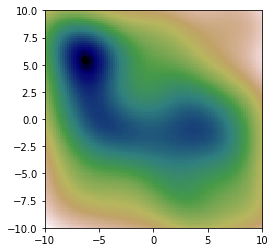

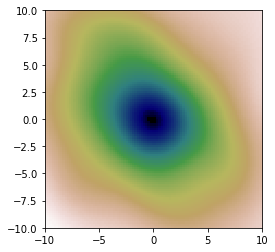

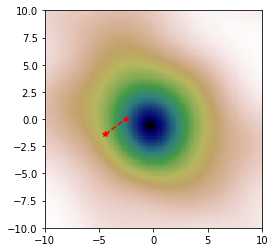

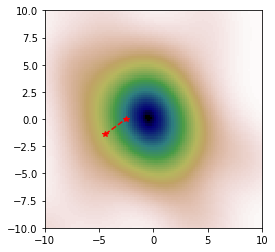

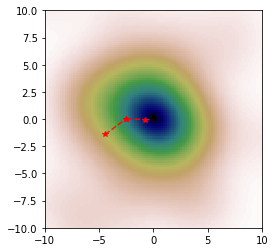

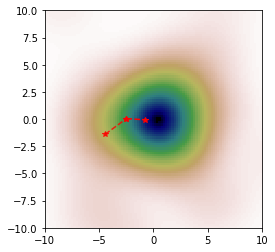

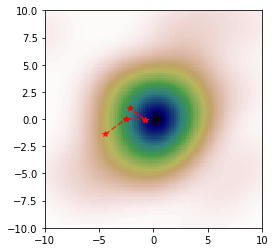

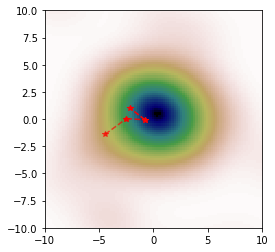

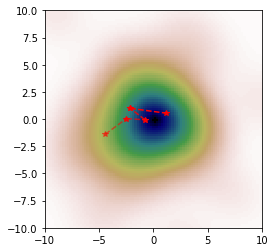

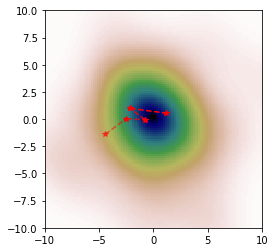

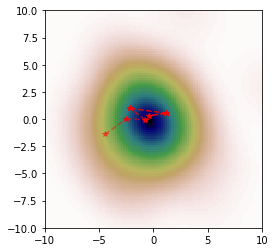

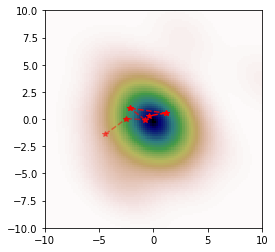

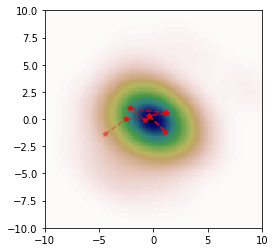

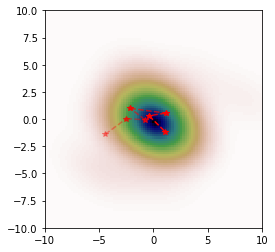

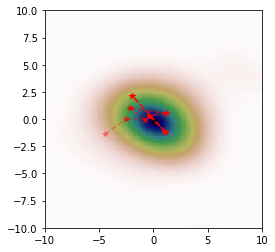

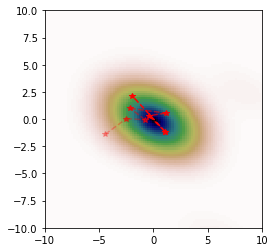

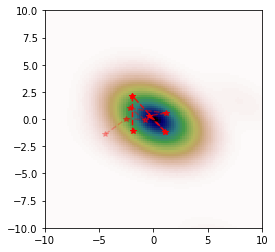

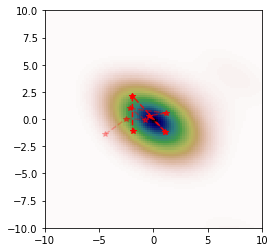

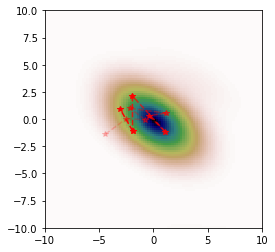

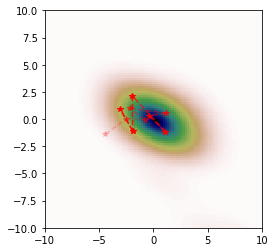

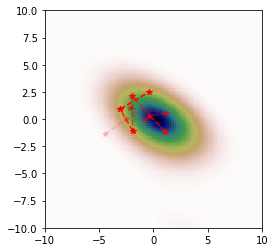

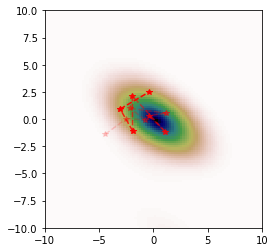

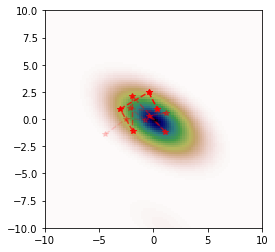

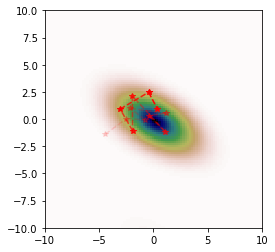

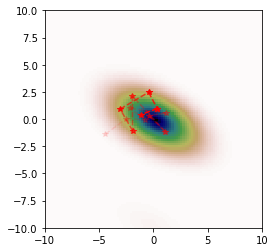

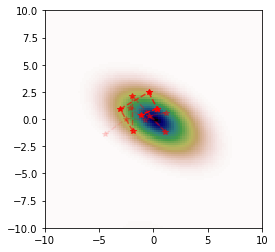

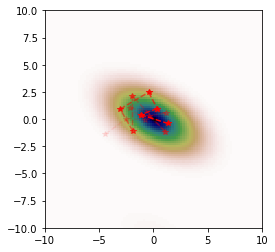

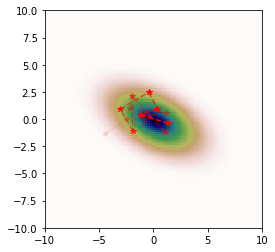

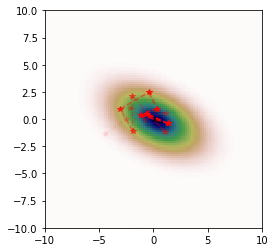

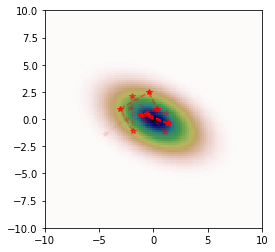

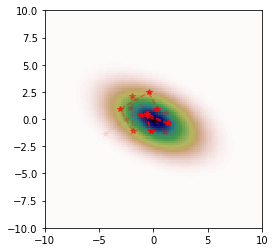

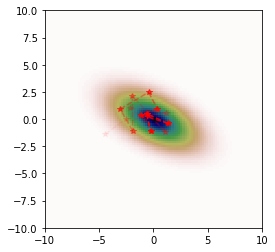

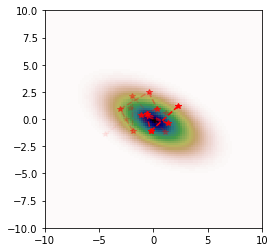

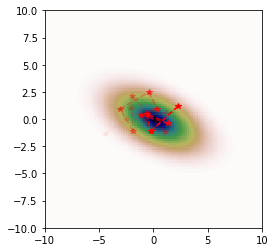

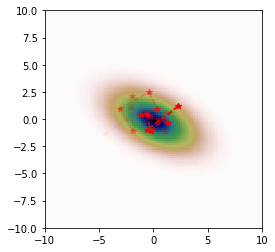

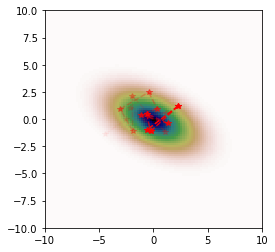

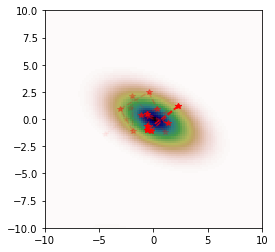

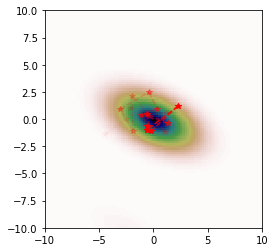

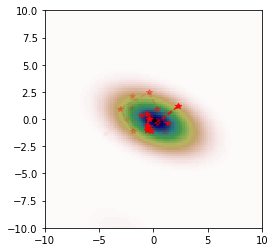

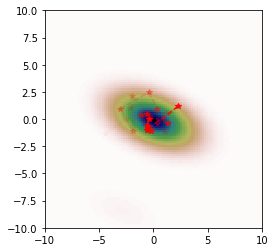

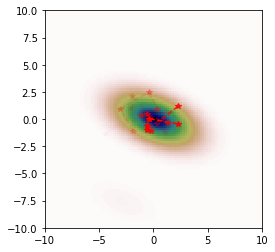

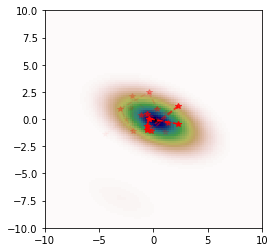

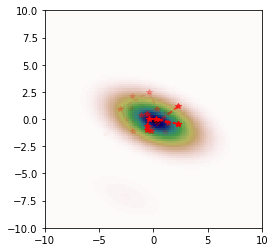

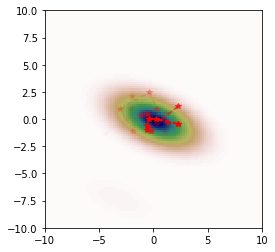

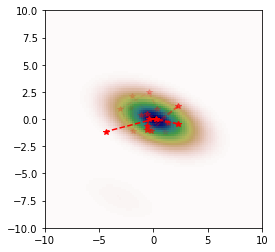

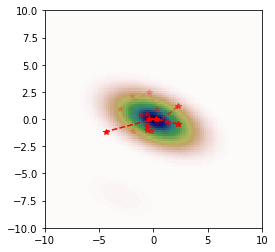

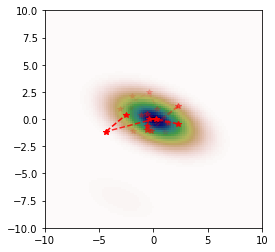

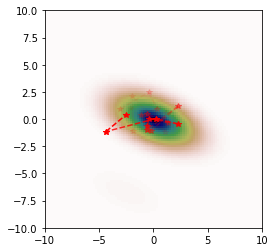

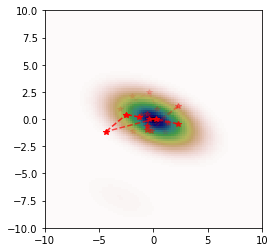

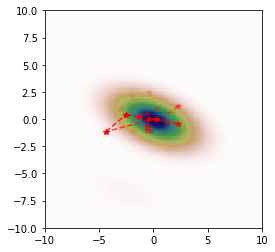

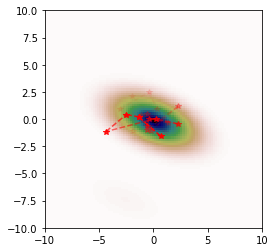

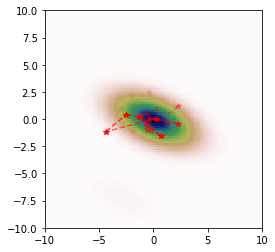

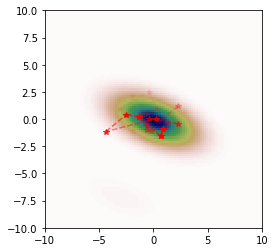

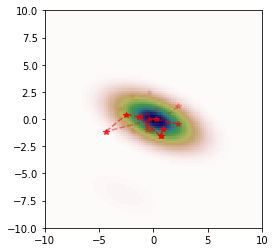

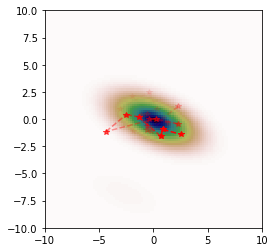

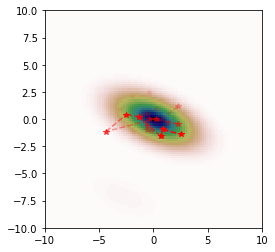

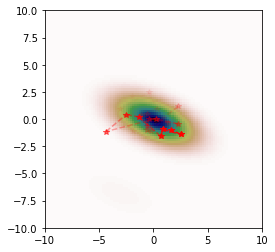

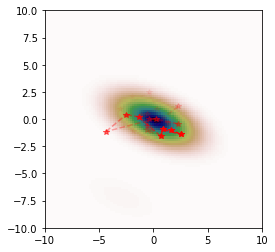

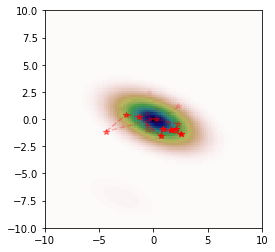

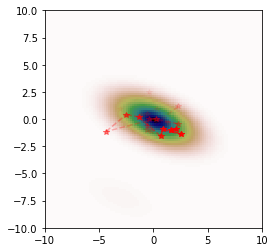

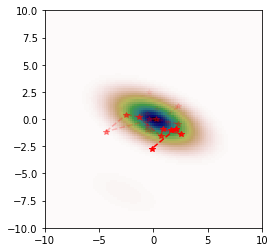

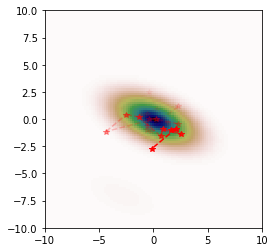

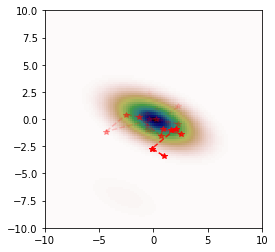

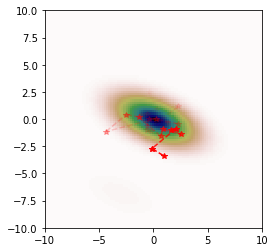

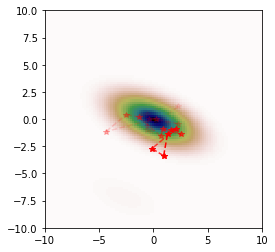

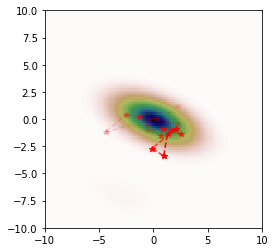

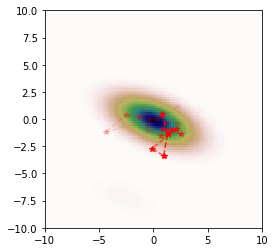

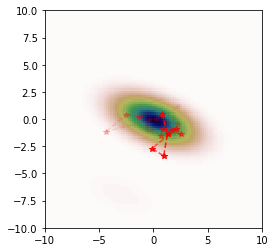

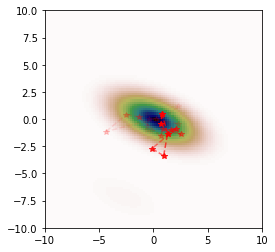

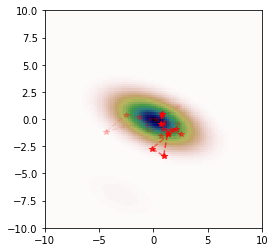

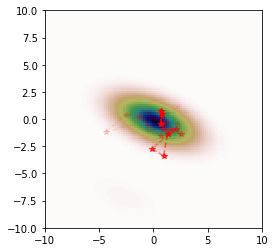

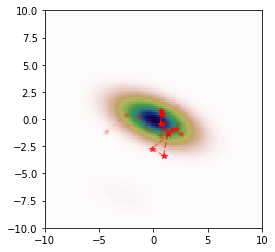

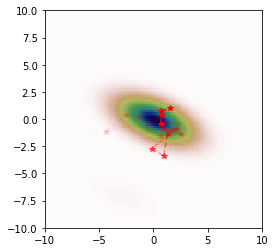

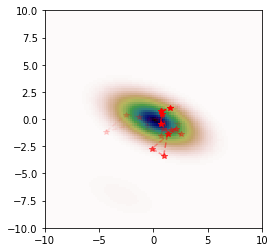

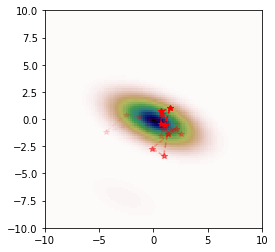

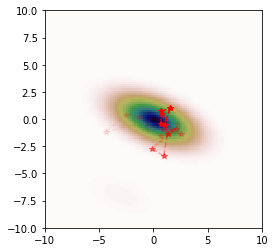

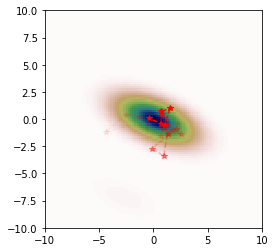

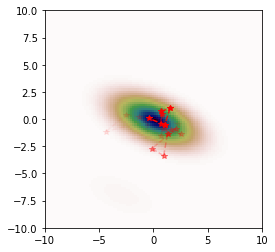

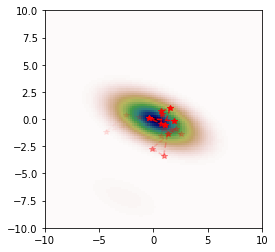

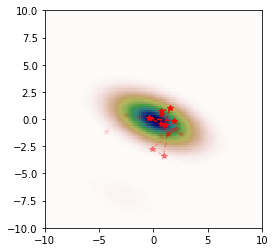

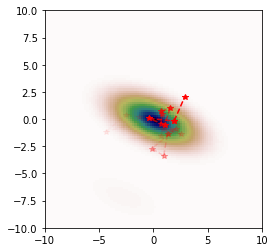

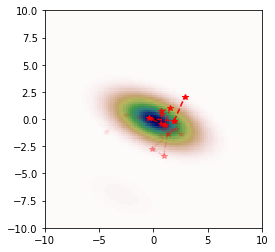

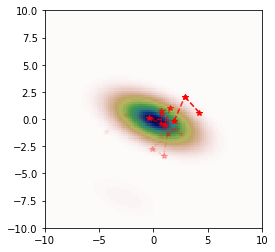

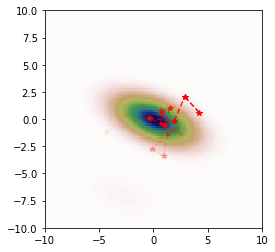

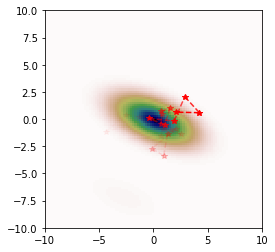

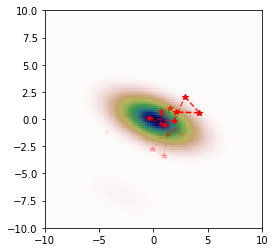

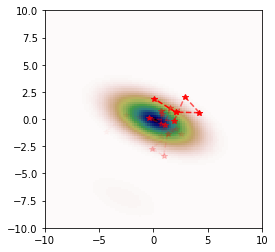

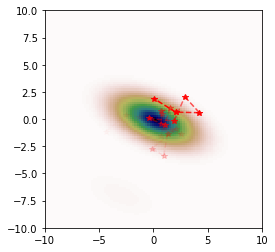

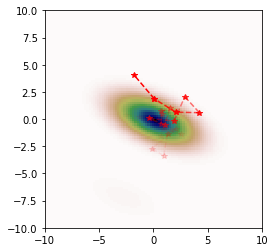

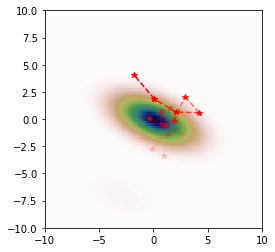

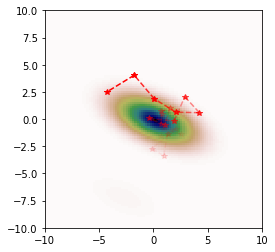

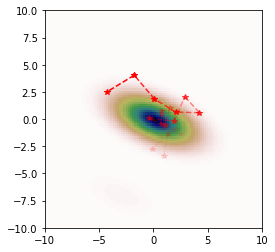

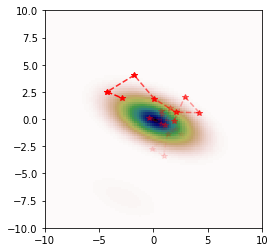

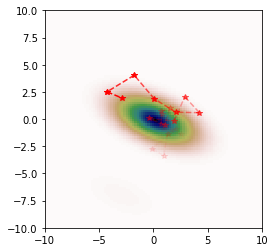

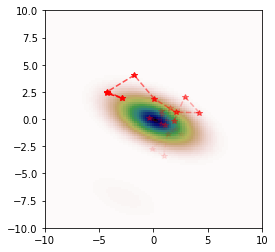

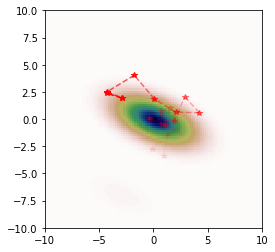

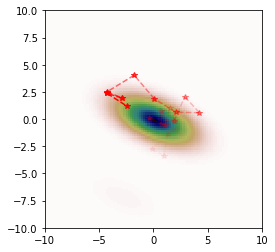

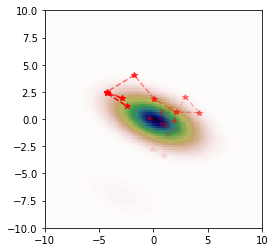

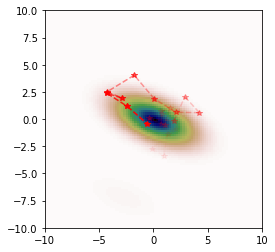

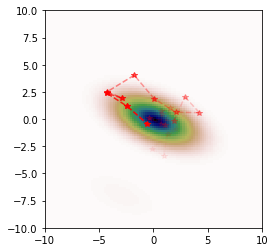

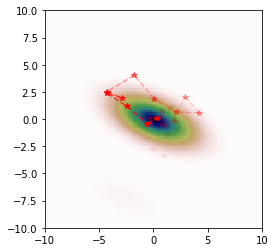

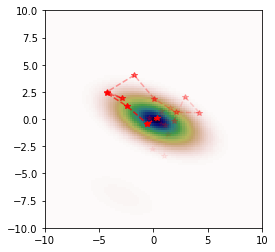

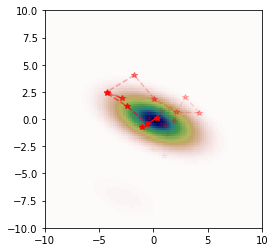

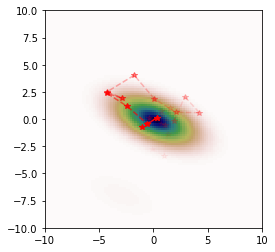

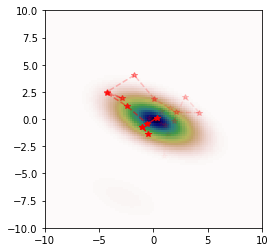

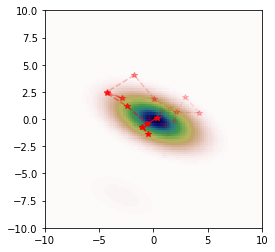

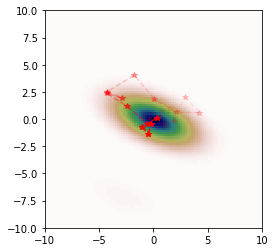

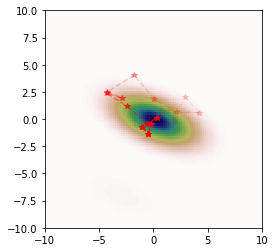

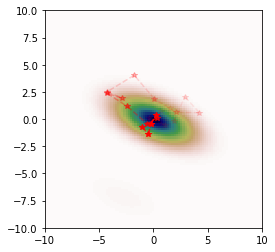

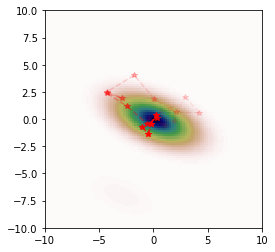

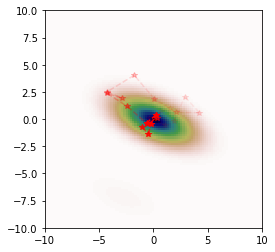

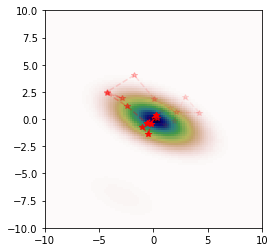

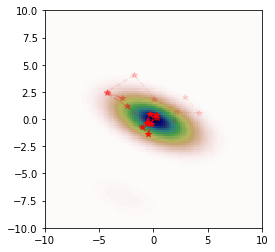

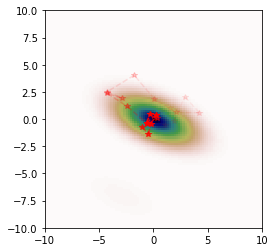

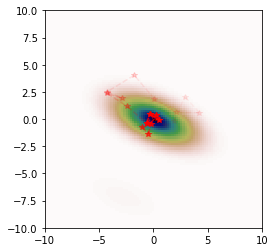

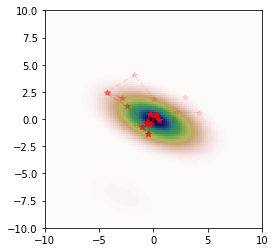

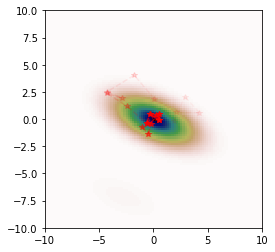

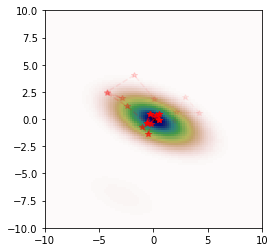

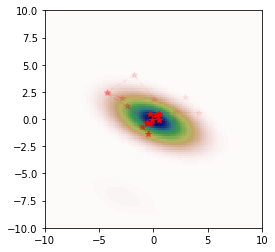

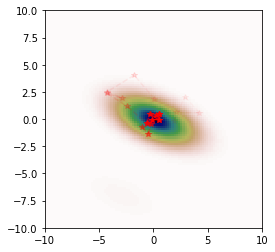

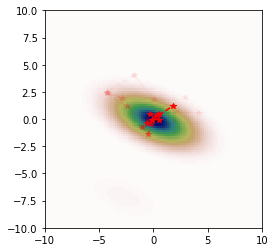

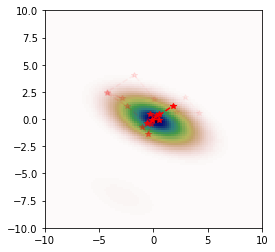

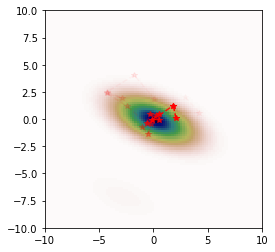

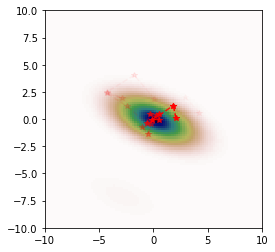

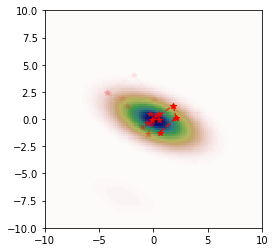

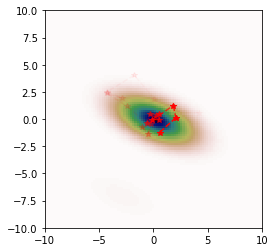

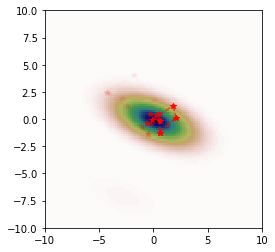

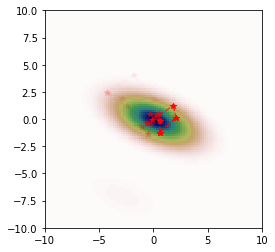

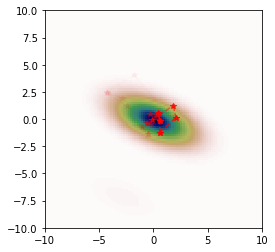

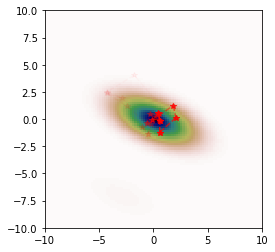

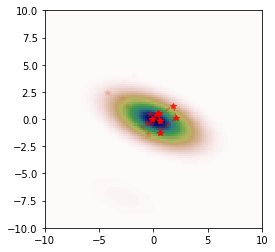

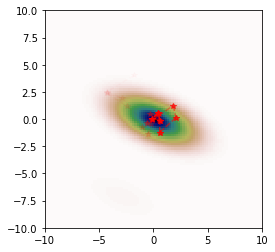

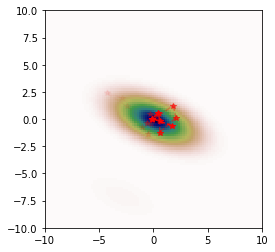

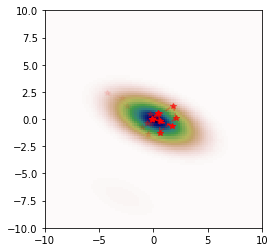

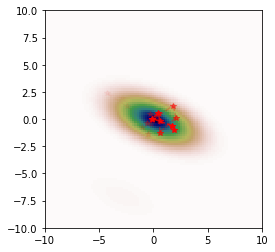

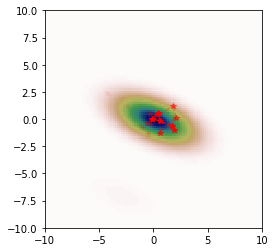

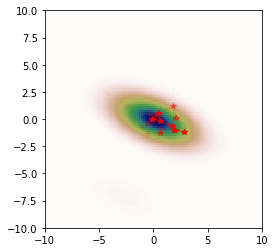

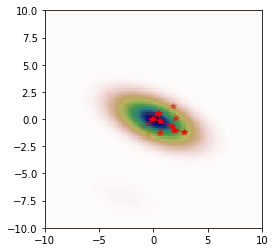

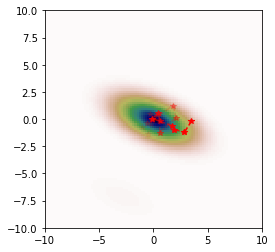

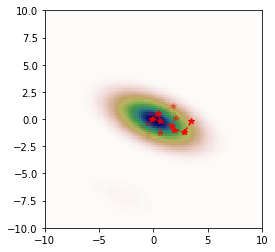

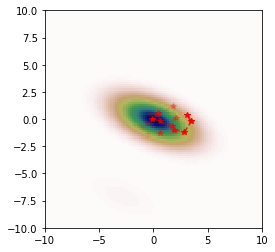

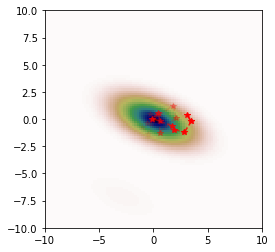

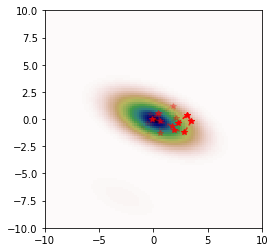

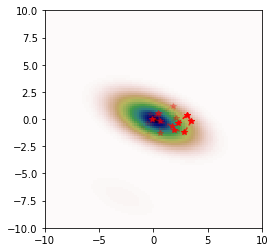

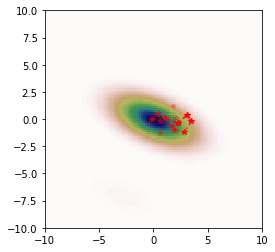

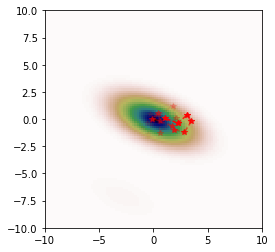

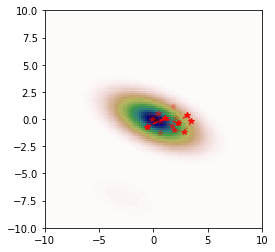

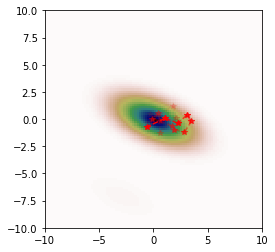

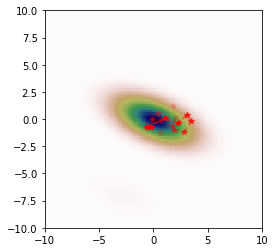

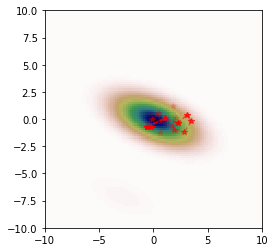

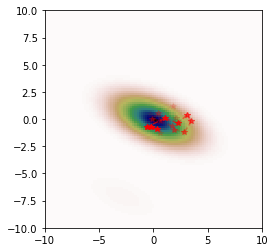

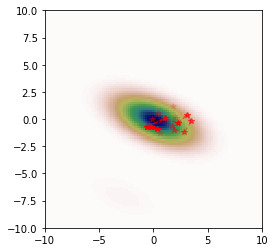

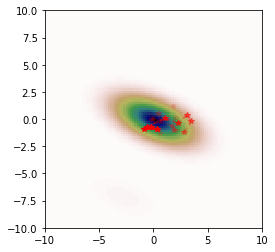

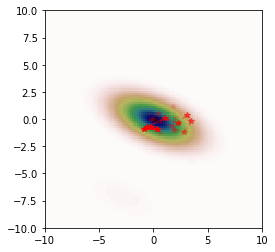

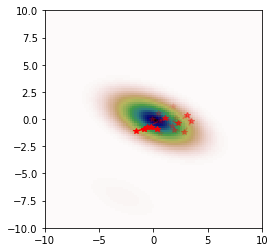

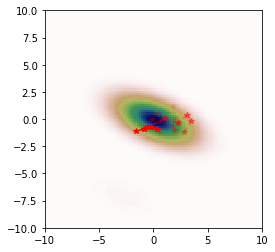

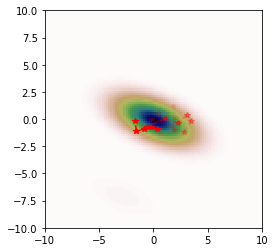

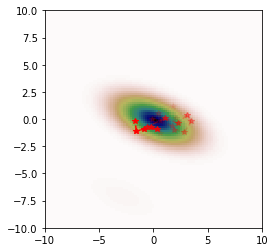

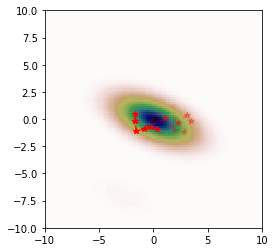

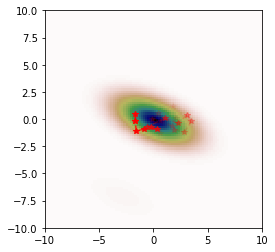

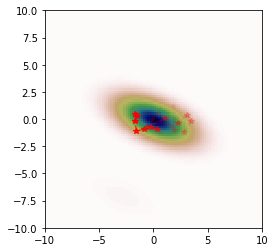

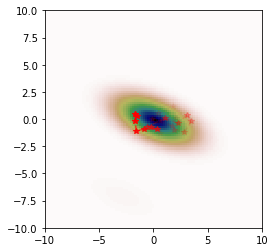

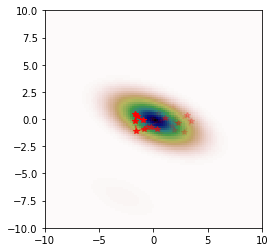

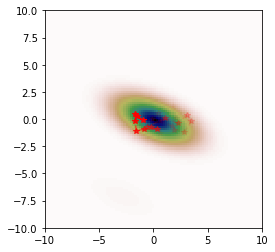

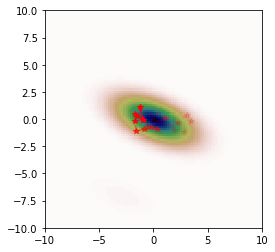

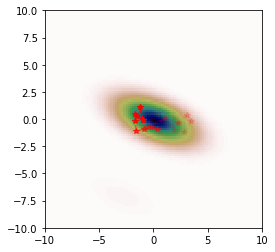

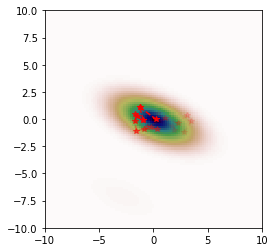

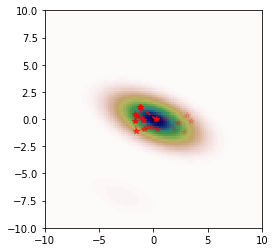

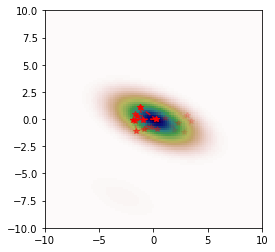

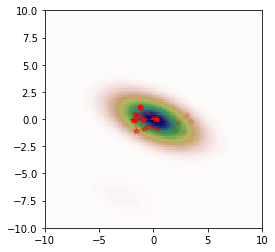

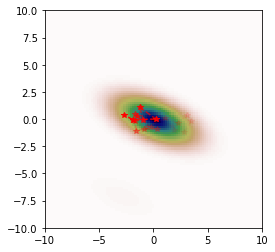

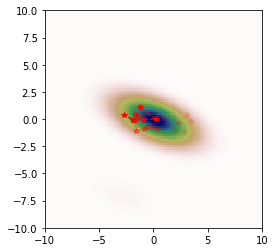

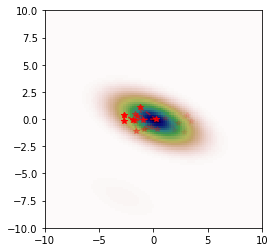

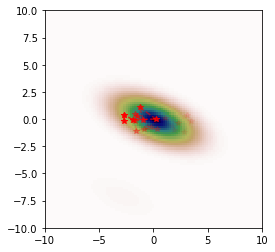

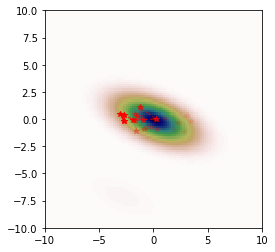

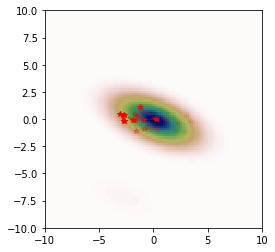

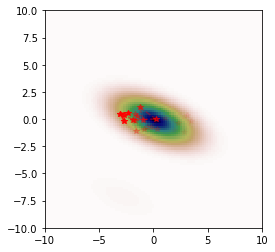

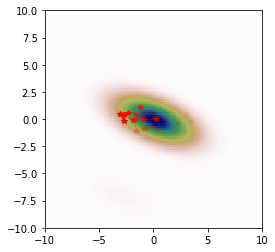

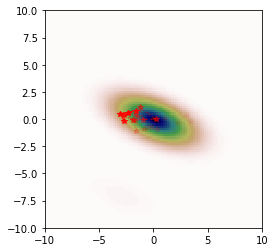

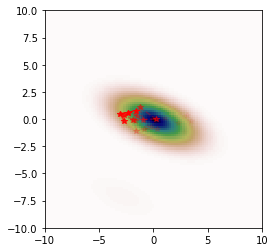

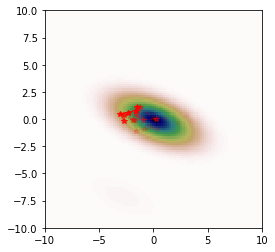

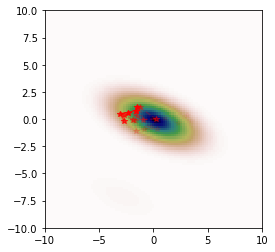

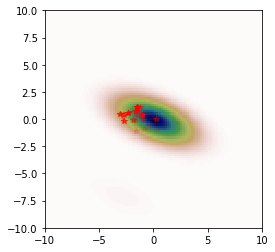

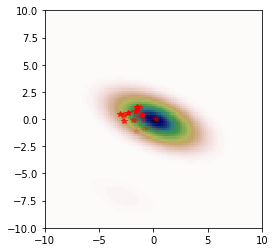

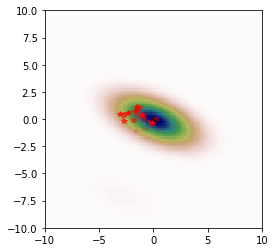

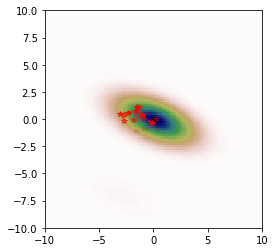

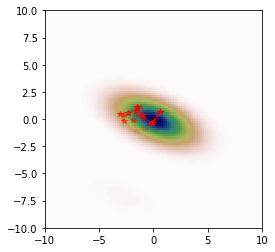

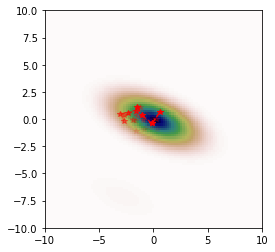

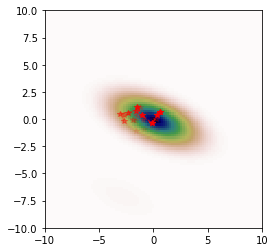

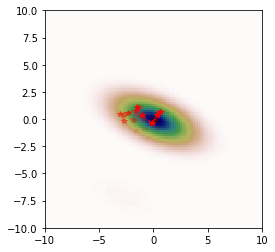

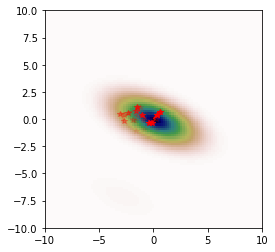

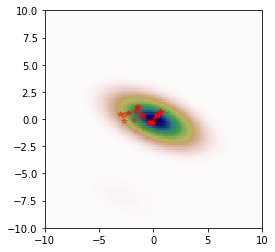

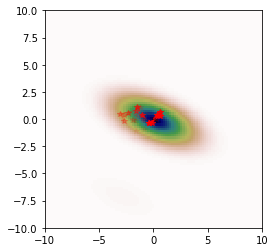

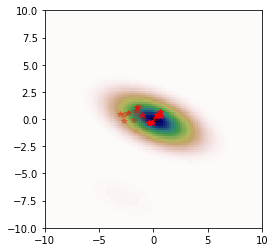

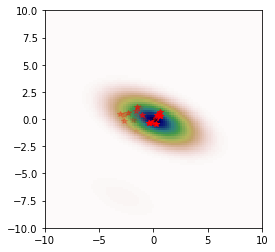

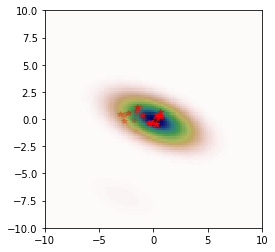

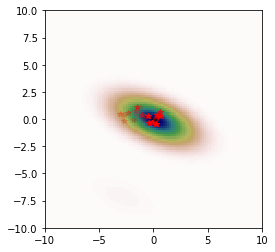

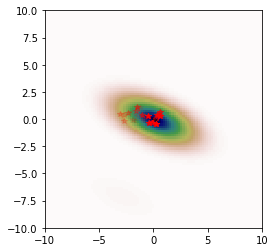

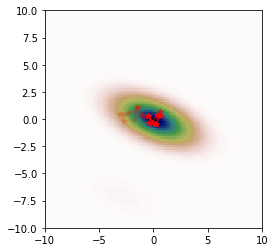

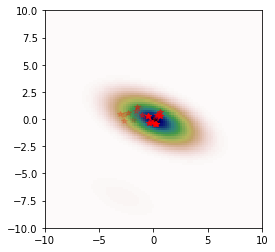

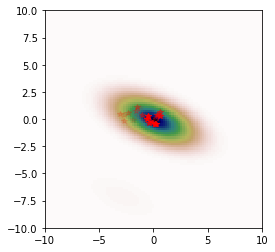

In [12]:
ani_path = create_animation_interactive_diffusion(np.array(p_path)[:, ::5, :], np.array(two_p_path))

In [13]:
create_animation(ani_path, "test.mp4", framerate=22)

In [4]:
def create_animation_density_particles_pictures(paths):
    """
    Assume all paths have same length"""
    if not os.path.isdir("./tmp"):
        os.mkdir("./tmp")
    ani_path = "./tmp/density_{}".format(time.time())
    os.mkdir(ani_path)

    for i in range(len(paths[0])):
        fig, ax = plt.subplots()
        ax.set_xlim(-35, 35)
        ax.set_ylim(-35, 35)
        ax.plot(paths[:, i, 0, :], paths[:, i, 1, :], "o")

        plt.savefig(ani_path + "/{}.png".format(i))
    return ani_path

In [5]:
def create_animation_density_pictures(paths):
    """
    Assume all paths have same length"""
    if not os.path.isdir("./tmp"):
        os.mkdir("./tmp")
    ani_path = "./tmp/density_{}".format(time.time())
    os.mkdir(ani_path)

    for i in range(len(paths[0])):
        X = paths[:, i, 0].T[0]
        Y = paths[:, i, 1].T[0]
        
        kernel = stats.gaussian_kde(np.vstack([X, Y]))
        x_min, x_max = max(-15, min(X)), min(15, max(X))
        y_min, y_max = max(-15, min(Y)),min(15, max(Y))
        positions = np.mgrid[x_min:x_max:0.2, y_min:y_max:0.2]
        
        Z = np.reshape(kernel(np.vstack([positions[0].ravel(), positions[1].ravel()])).T, positions[0].shape)

        fig, ax = plt.subplots()
        ax.imshow(Z, cmap=plt.cm.gist_earth_r,  extent=[x_min, x_max, y_min, y_max])

        plt.savefig(ani_path + "/{}.png".format(i))
    return ani_path

In [6]:
%load_ext autoreload
%autoreload 1

In [3]:
def gamma(t):
    return 0.5/((t // 50) + 1)

def temperature(t):
    return 0.7/((t // 75) + 1)

In [4]:
# A = np.array([[1, 0], [0, 1]])
# b = 0
# f = QuadraticFunctionInit(A, b)
# f_grad = GradQuadraticFunctionInit(A)

f = AckleyProblem
f_grad = GradAckleyProblem


In [9]:
def interactive_diffusion(U, grad_U, first_p_start, second_p_start, N_iter, num_particles, N_particles_iter, k, verbose=False):
    dim = len(second_p_start)
    
    kernel = multi_gaussian(np.eye(dim))
    grad_kernel = grad_gaussian(np.eye(dim))
    
    # init num_particles
    particles_path = [np.array([p]) for p in first_p_start]
    
    # init second_particles
    second_particle_path = [second_p_start]
    
    for t in range(N_iter):
        # run n particles N_particles_iter times
        curr_paths = []
        for i in range(num_particles):
            p = particles_path[i][-1]
            path = simulated_annealing_janky(U, grad_U, p, 1e-7, gamma, temperature, start_t=t*N_particles_iter , end_t=(t+1)*N_particles_iter)
            particles_path[i] = np.concatenate((particles_path[i], path[1:]), axis=0)

        # update second diffusion proccess
        U_second_use = U
        grad_U_second_use = grad_U_second(grad_U, k, grad_kernel, particles_path[-1])
        path = simulated_annealing_janky(U_second_use, grad_U_second_use, second_particle_path[-1].T, 0, gamma, temperature, start_t=t , end_t=t+1)
        second_particle_path.append(path[-1].T)
        
        
        if verbose:
            if t % 100 == 0:
                print("Iter: ", t)
    
    return np.array(particles_path), np.array(second_particle_path)
    
U = AckleyProblem
grad_U = GradAckleyProblem

dim = 2
N_iter = 100
num_particles = 100
N_particles_iter = 10
first_p_start = np.array([[10 * np.random.uniform(-1, 1) for _ in range(dim)] for _ in range(num_particles)])
second_p_start = np.array([10 * np.random.uniform(-1, 1) for _ in range(dim)])

p_path, two_p_path = interactive_diffusion(U, grad_U, first_p_start, second_p_start, N_iter, num_particles, N_particles_iter, k=1/2, verbose=True)
    

Iter:  0


Analytics 

Compare the two how fast they find the end. Like the paper? Otherwise start all processes with standard stuff and do.

In [10]:
p_path.shape

(100, 1001, 2)

In [55]:
paths = []
for i in range(1000):
    x_start = np.array([[10 * np.random.uniform(-1, 1)], [10 * np.random.uniform(-1, 1)]])
    path = simulated_annealing_janky(f, f_grad, x_start, 1e-7, gamma, temperature, start_t=0 , end_t=250)
    paths.append(path)
paths = np.array(paths)

KeyboardInterrupt: 

In [63]:
X = paths[:, 5, 0].T[0]
Y = paths[:, 5, 1].T[0]

In [64]:
np.vstack([X, Y])

array([[-5.02097381e-01, -1.35022320e+00,  5.66423281e+00, ...,
         2.61960548e+00,  3.33435806e+00,  5.69846740e+00],
       [ 9.31495658e-03, -5.59600212e+00,  3.58967138e-01, ...,
        -1.08600040e+01,  9.50744288e-01, -1.63188875e+00]])

In [69]:
kernel = stats.gaussian_kde(np.vstack([X, Y]))
positions = np.mgrid[-10:10:0.1, -10:10:0.1]
Z = np.reshape(kernel(np.vstack([positions[0].ravel(), positions[1].ravel()])).T, positions[0].shape)

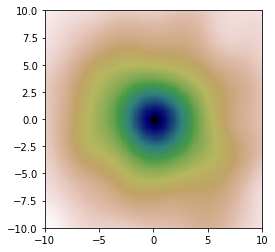

In [70]:
fig, ax = plt.subplots()
ax.imshow(Z, cmap=plt.cm.gist_earth_r,  extent=[-10, 10, -10, 10])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


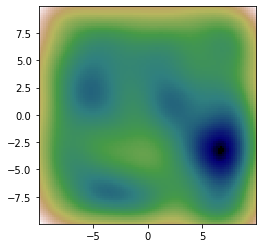

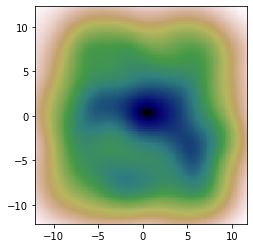

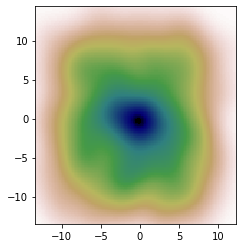

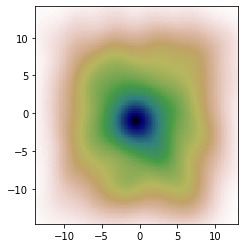

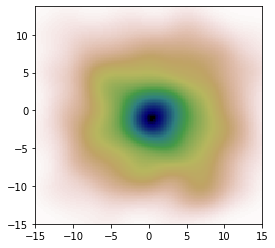

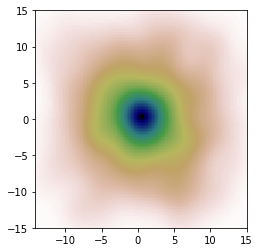

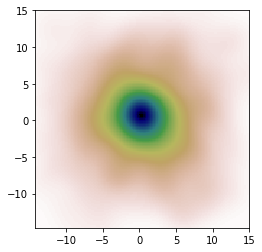

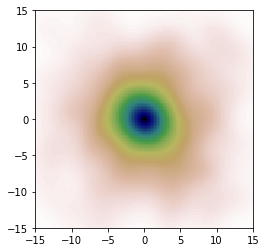

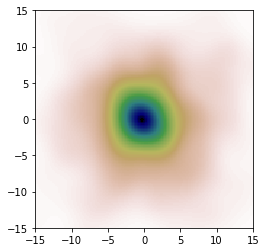

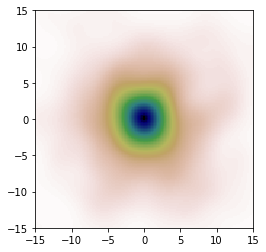

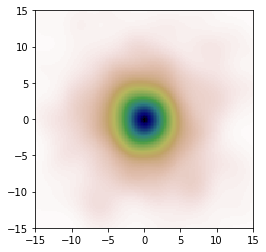

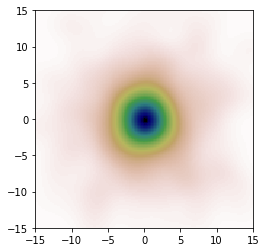

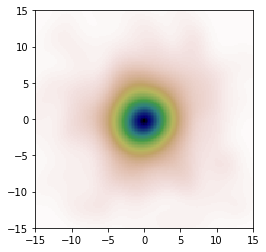

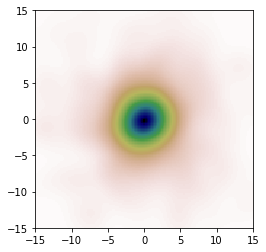

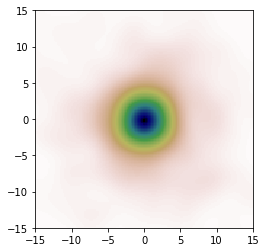

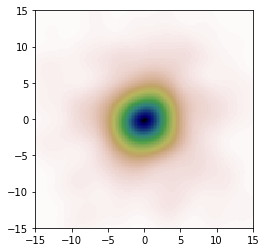

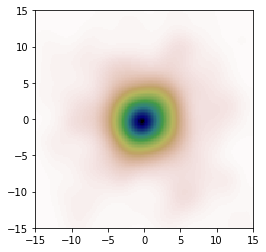

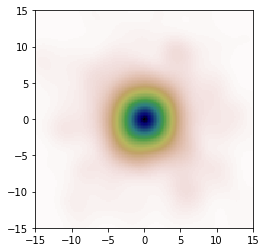

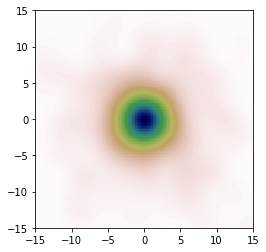

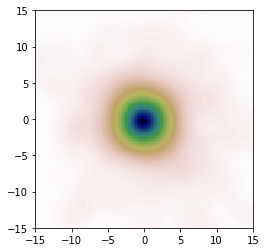

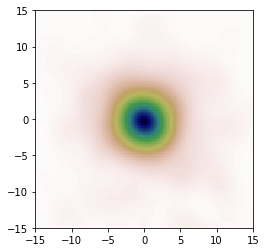

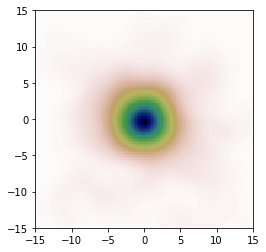

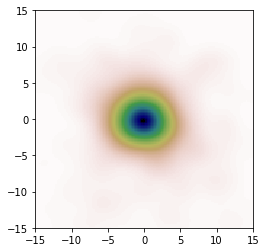

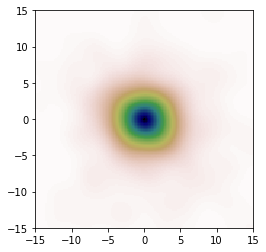

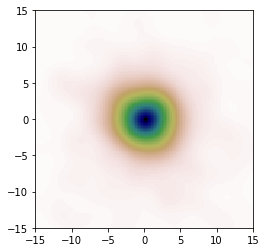

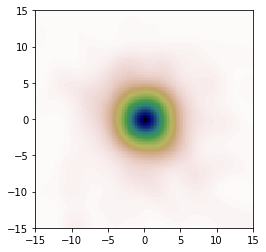

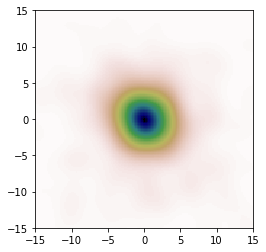

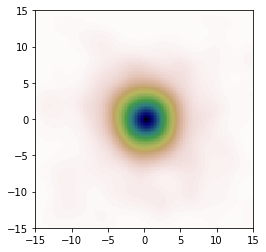

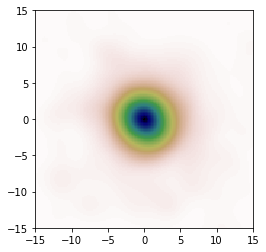

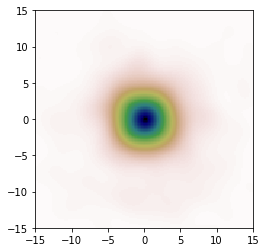

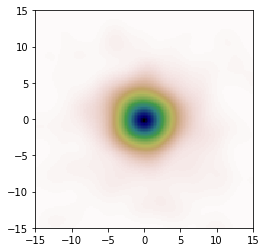

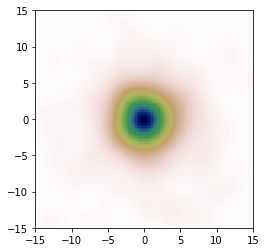

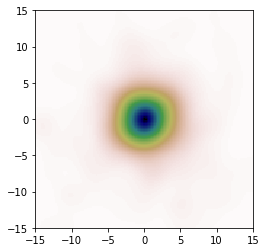

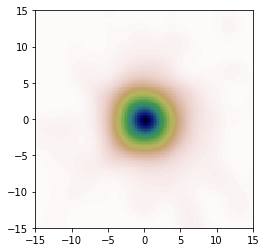

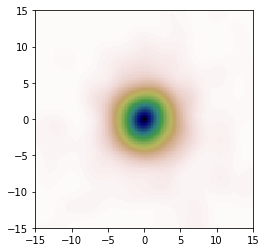

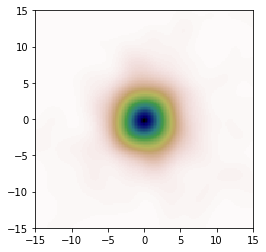

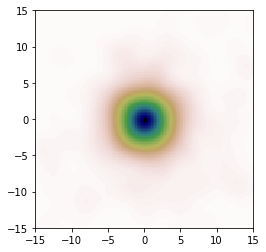

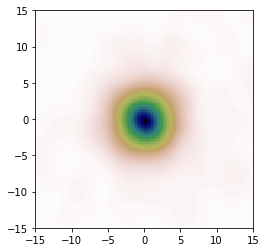

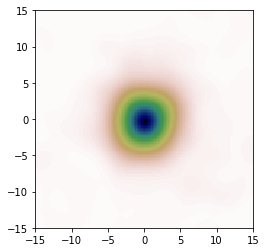

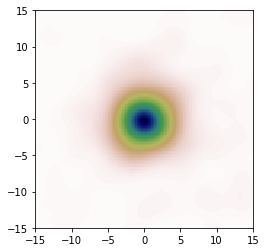

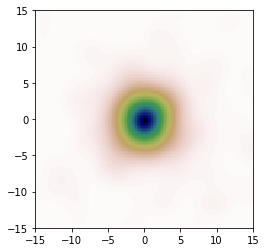

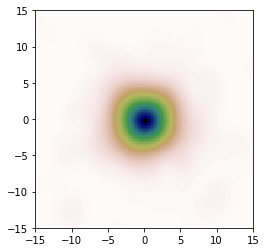

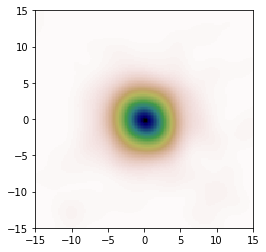

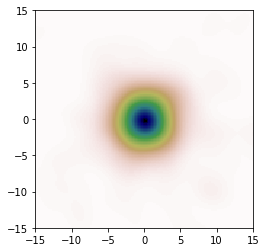

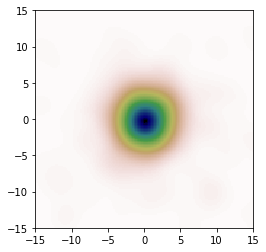

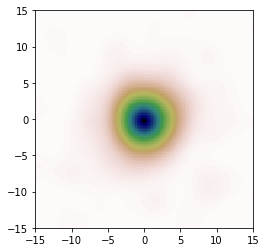

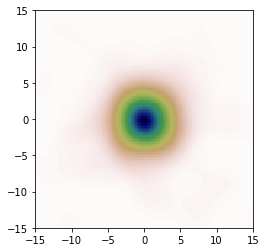

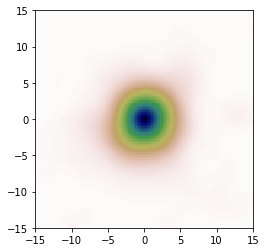

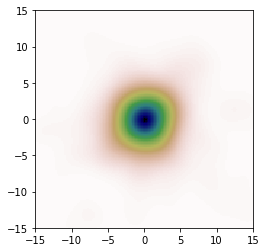

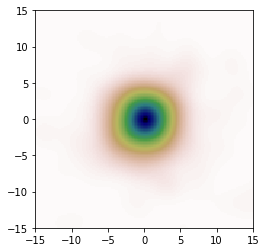

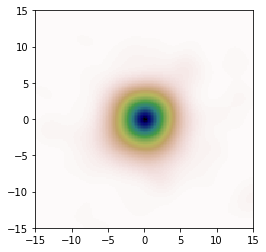

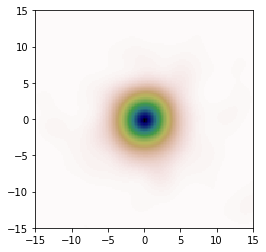

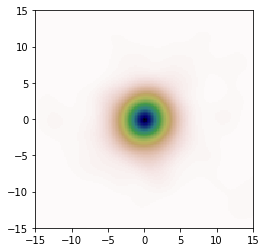

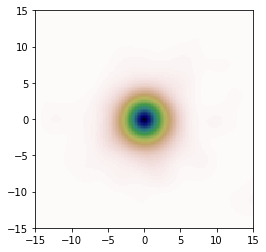

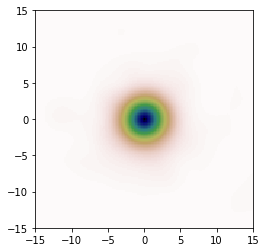

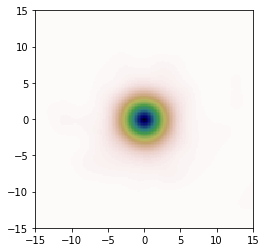

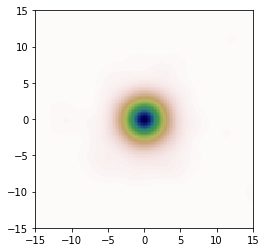

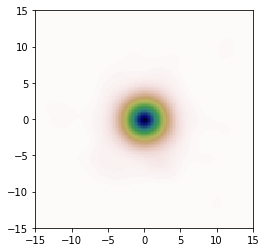

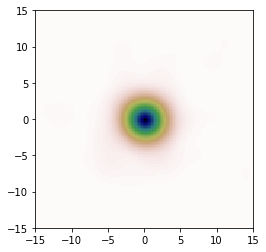

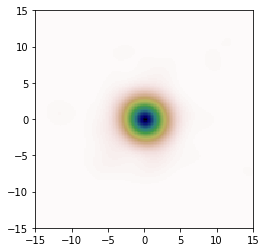

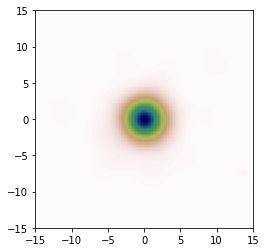

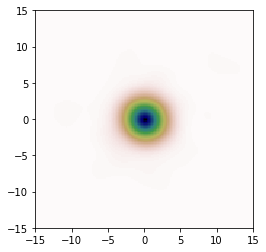

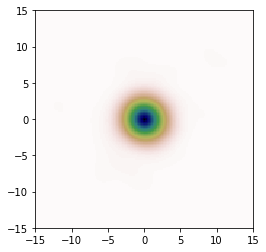

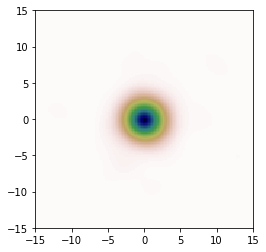

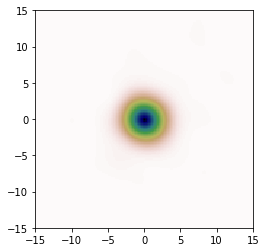

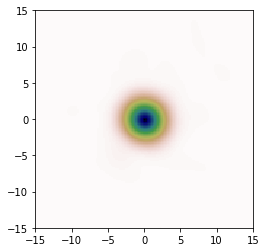

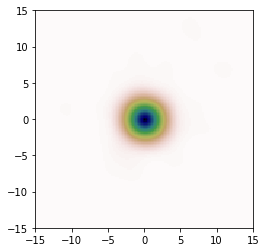

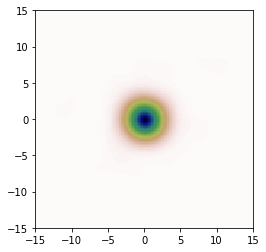

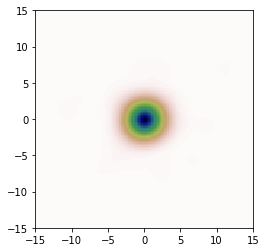

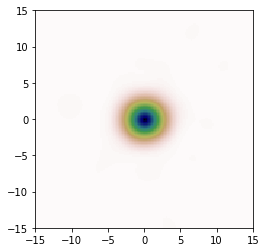

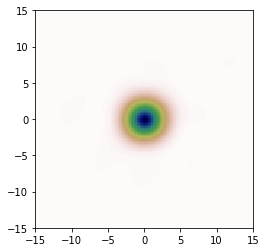

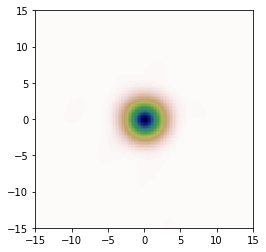

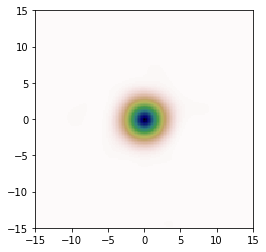

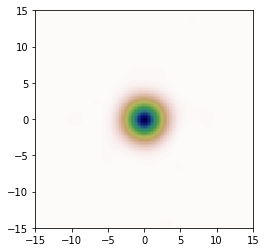

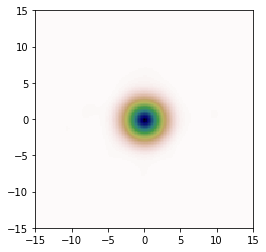

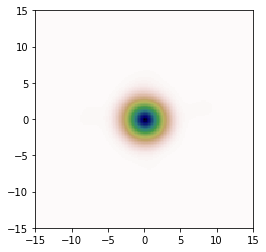

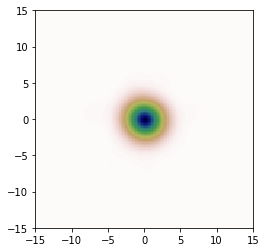

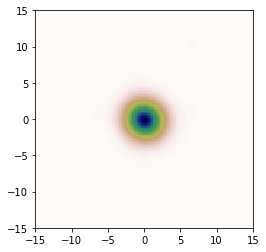

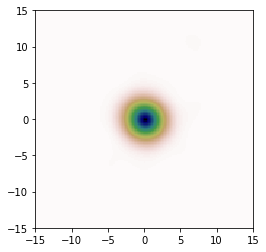

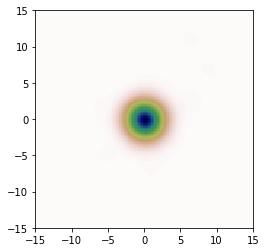

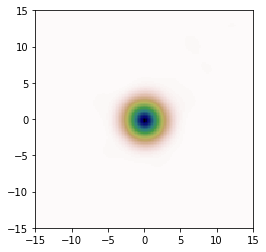

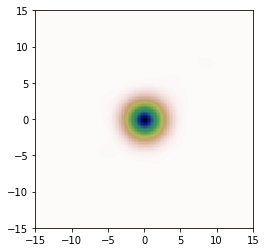

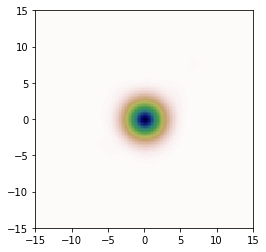

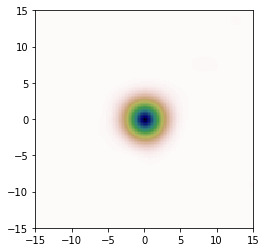

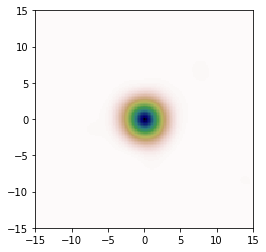

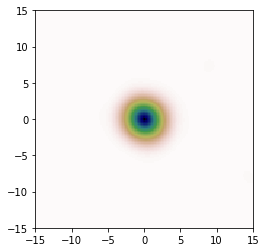

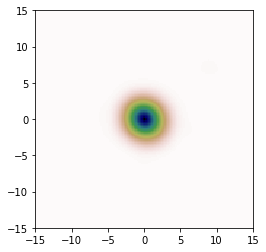

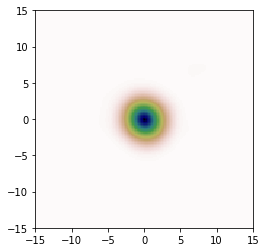

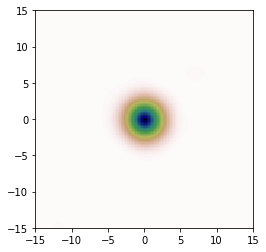

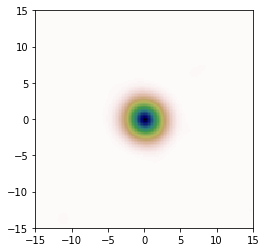

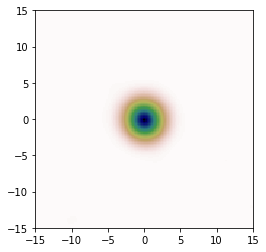

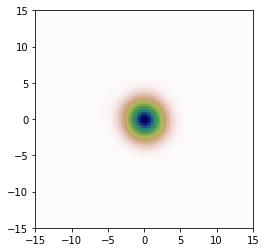

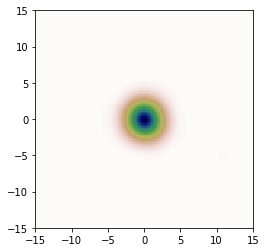

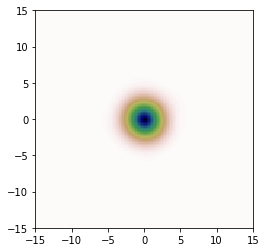

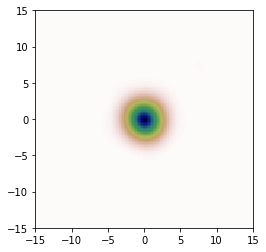

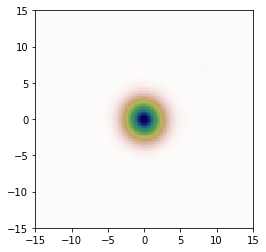

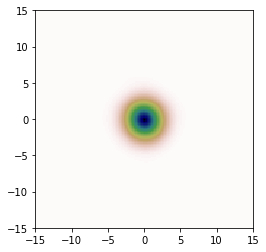

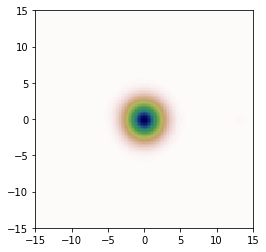

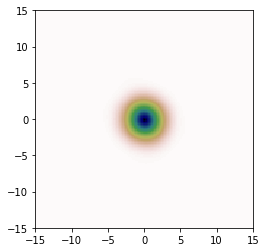

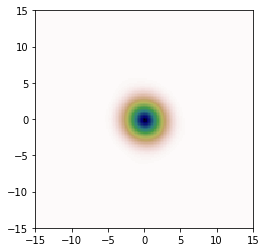

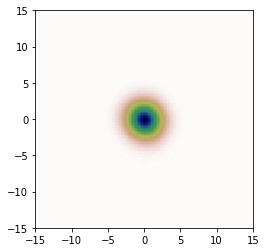

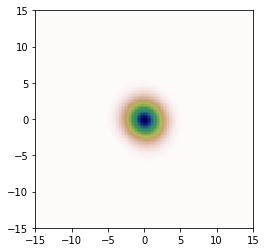

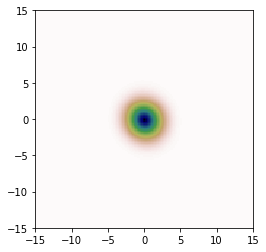

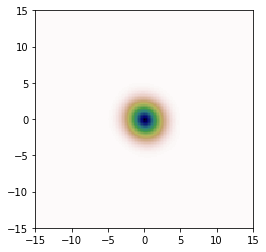

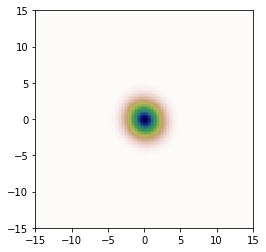

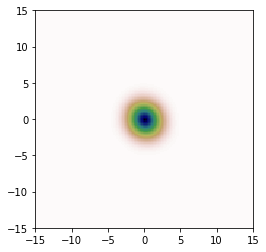

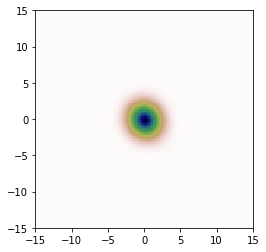

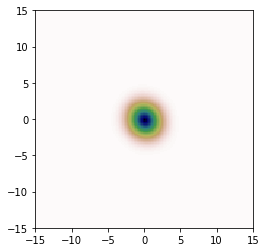

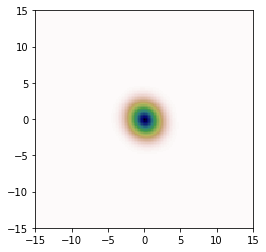

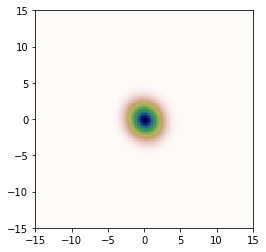

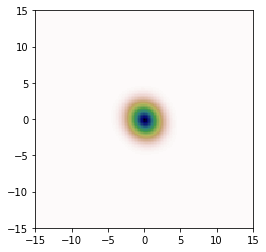

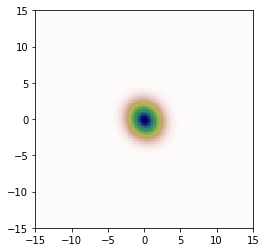

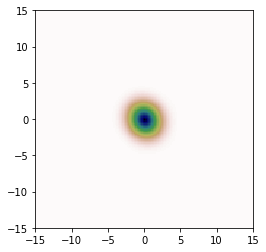

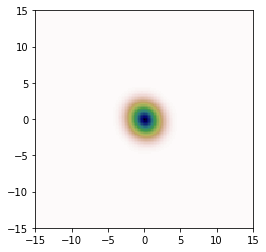

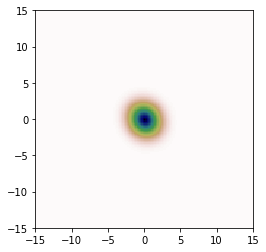

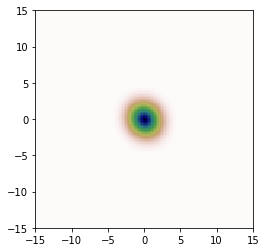

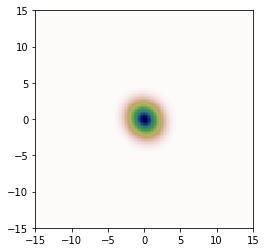

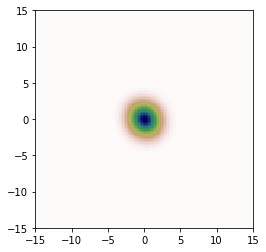

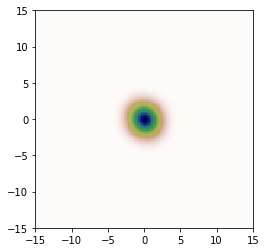

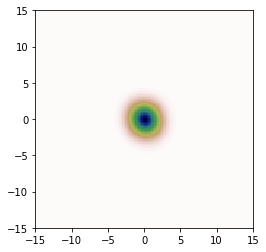

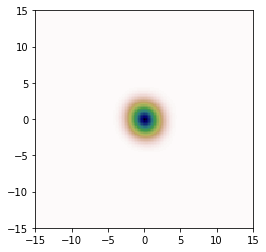

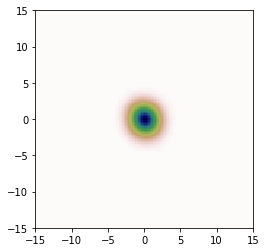

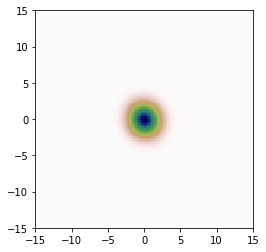

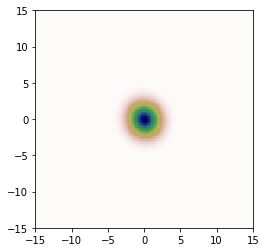

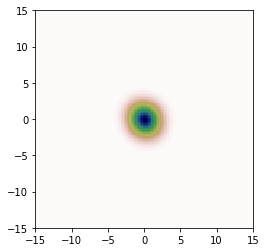

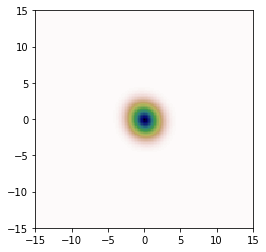

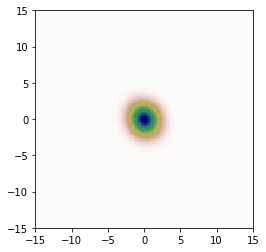

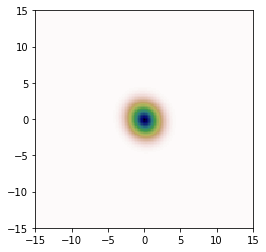

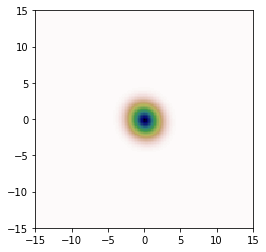

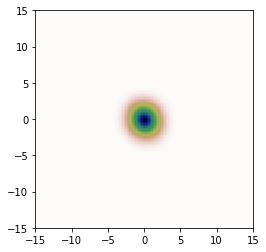

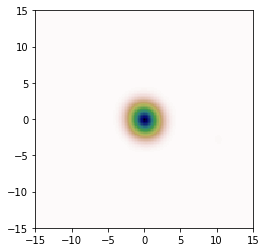

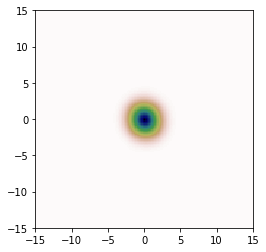

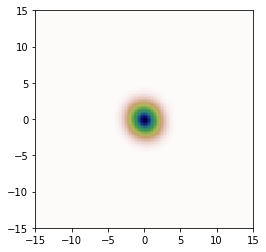

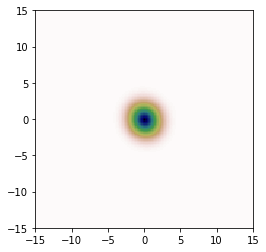

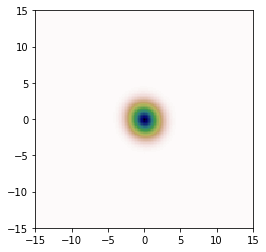

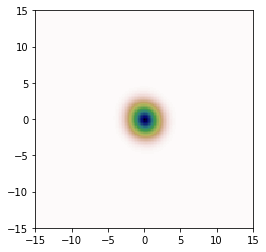

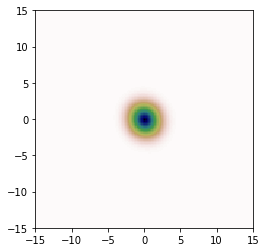

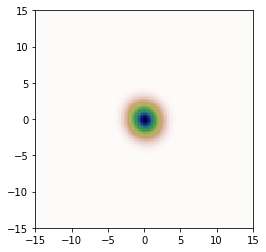

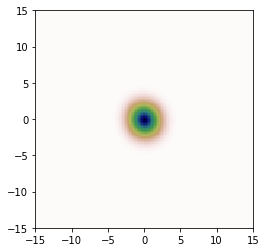

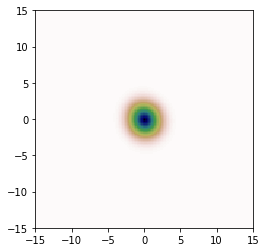

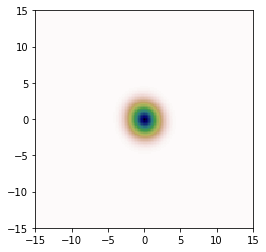

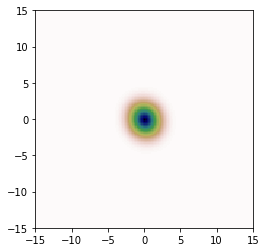

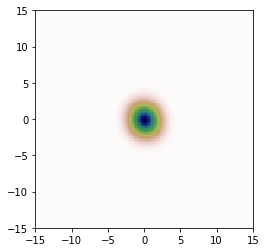

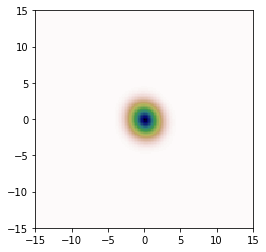

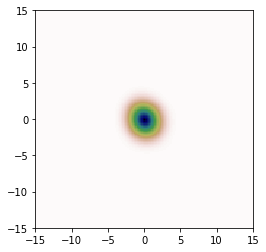

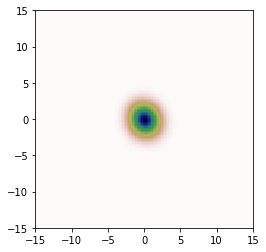

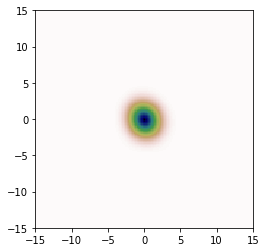

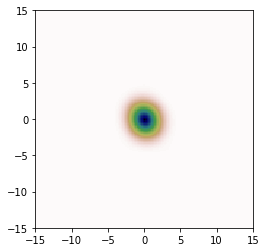

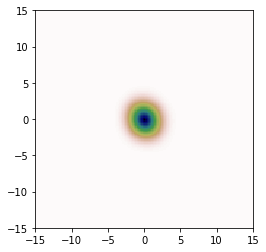

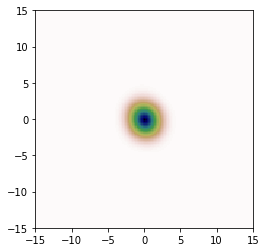

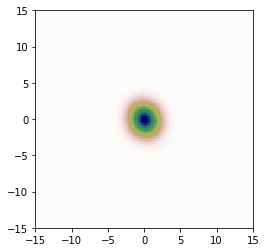

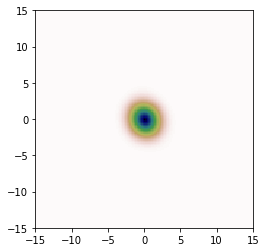

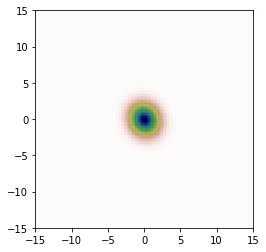

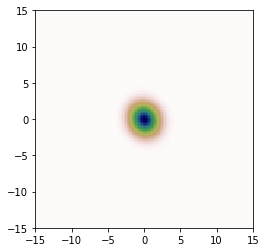

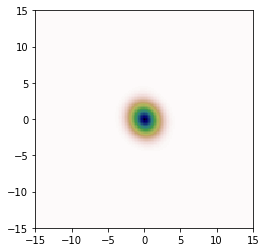

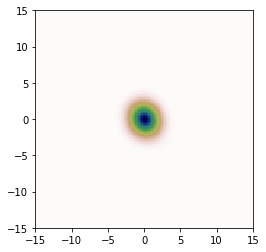

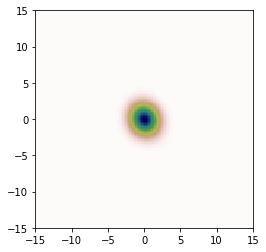

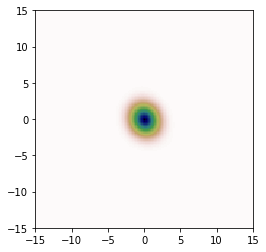

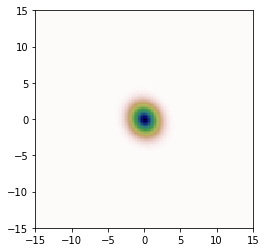

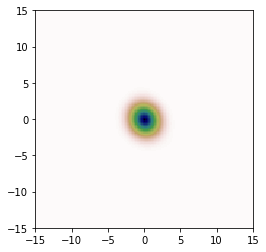

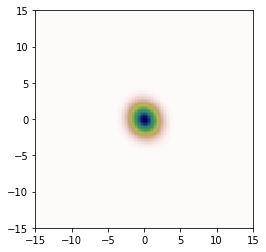

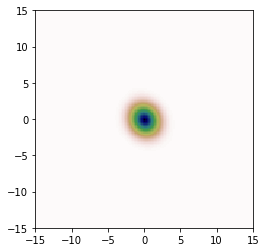

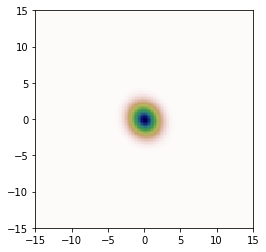

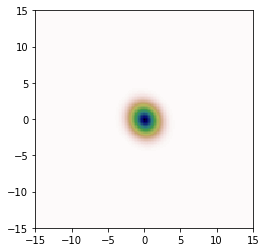

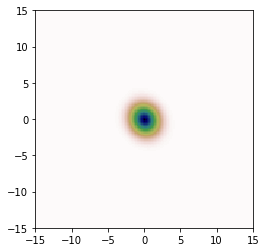

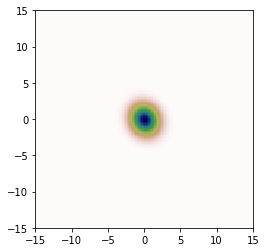

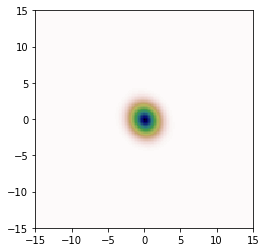

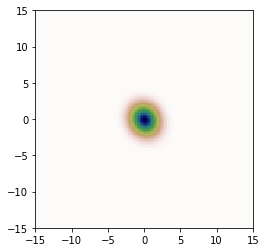

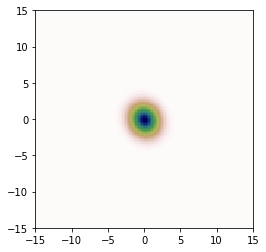

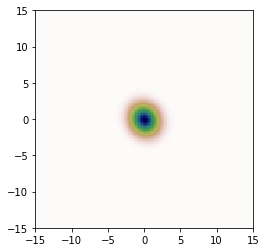

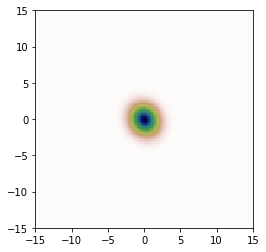

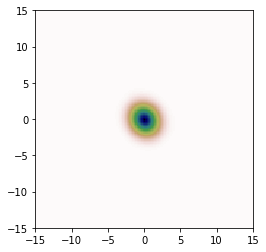

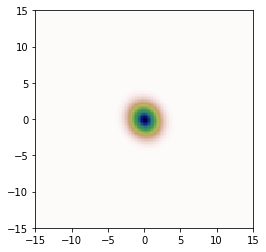

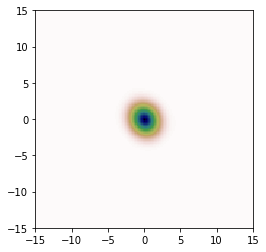

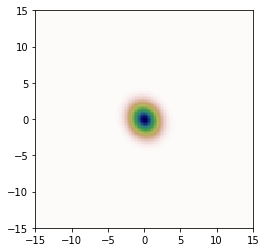

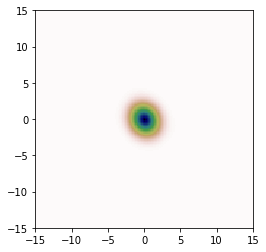

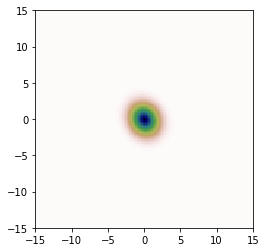

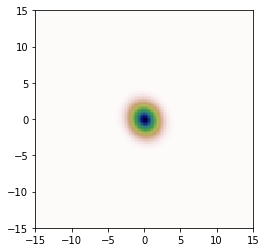

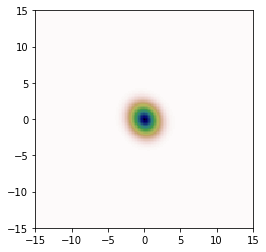

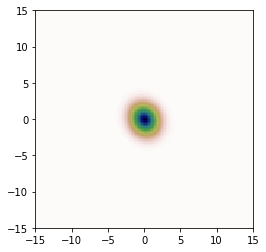

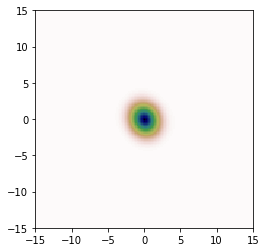

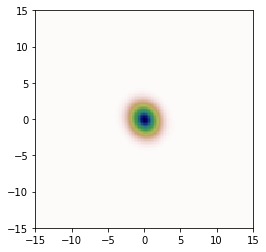

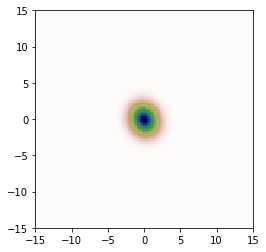

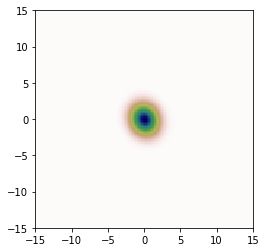

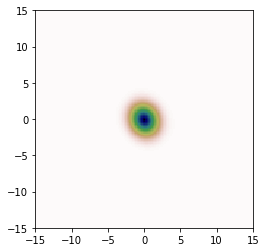

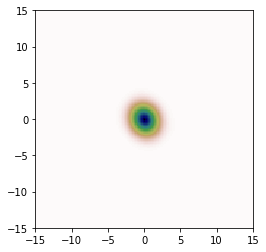

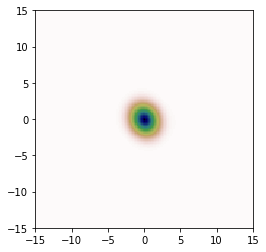

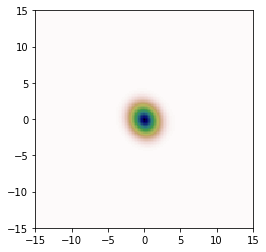

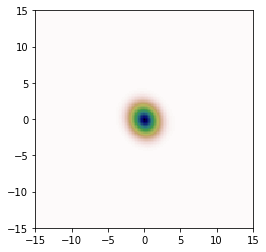

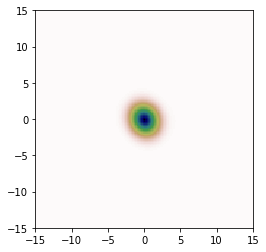

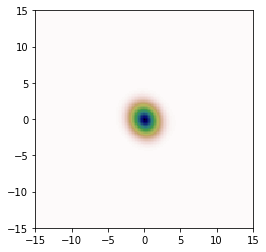

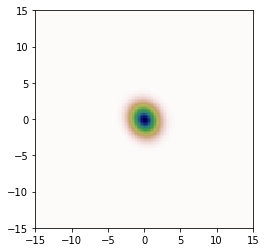

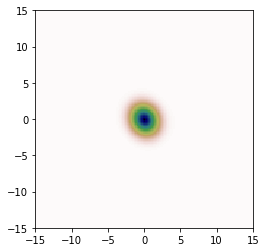

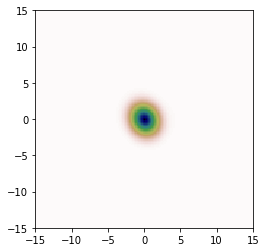

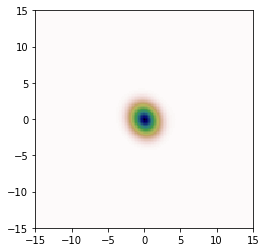

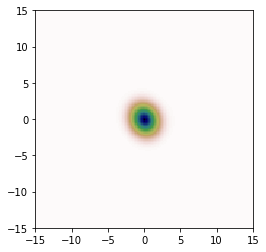

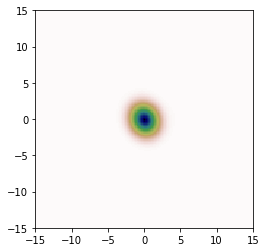

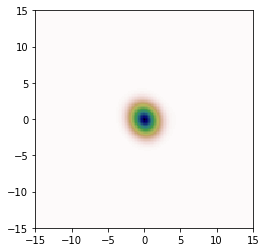

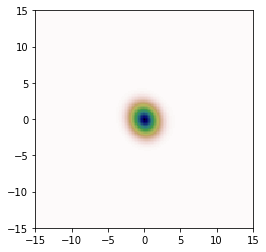

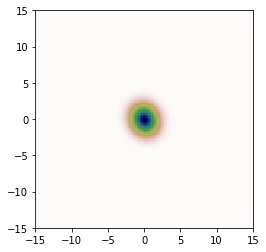

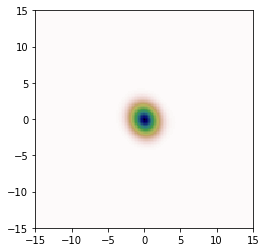

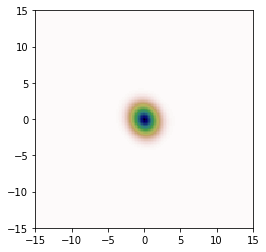

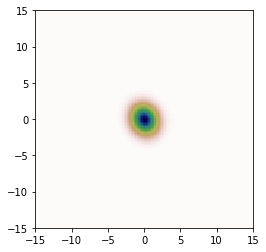

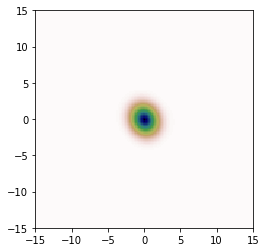

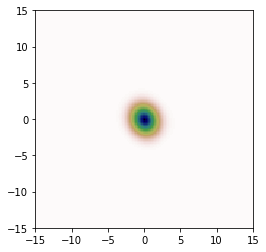

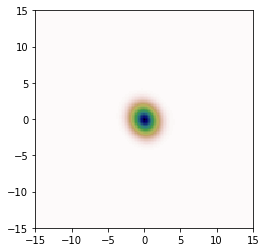

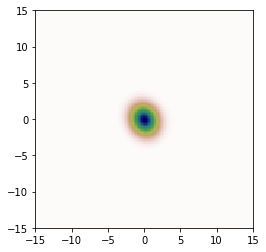

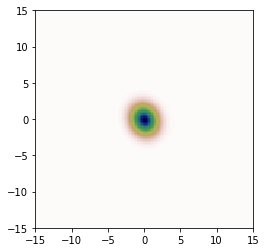

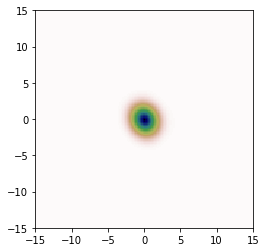

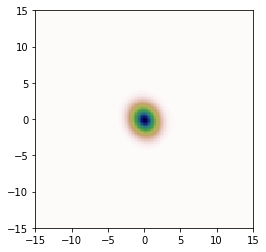

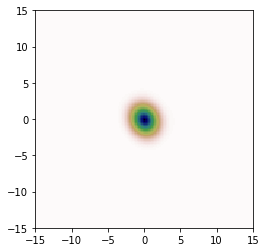

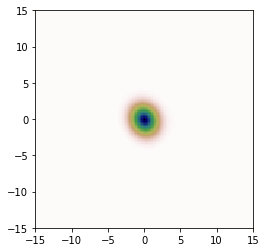

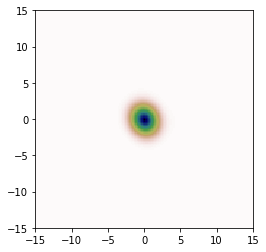

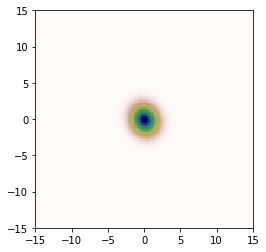

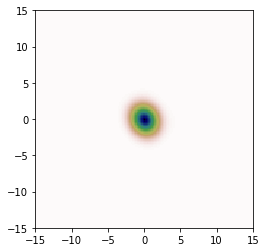

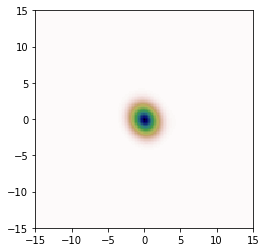

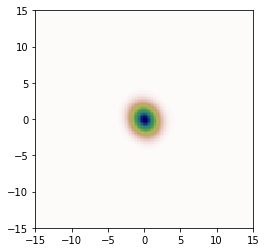

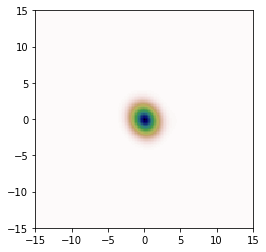

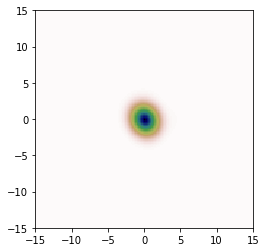

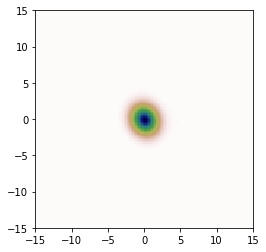

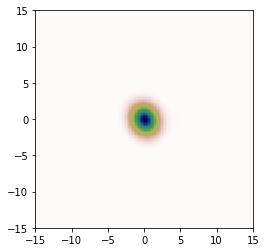

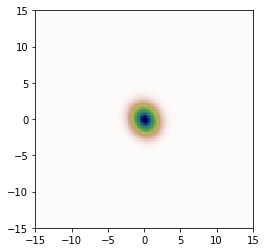

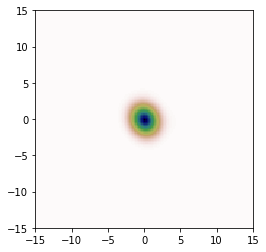

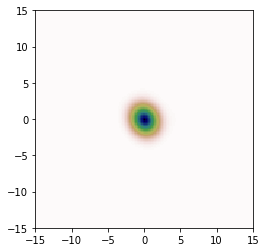

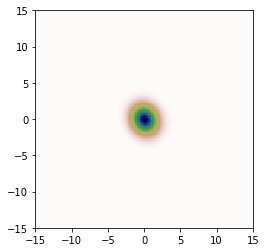

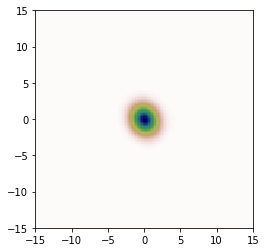

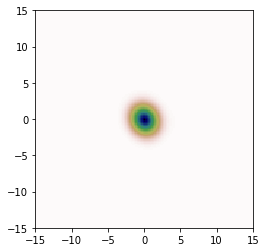

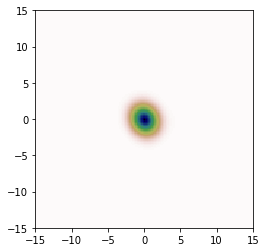

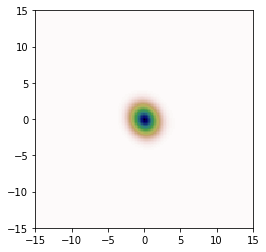

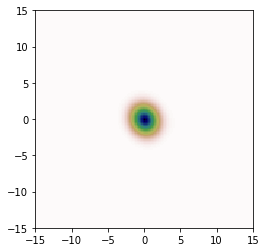

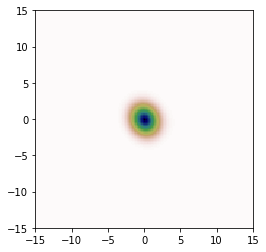

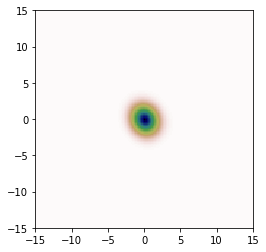

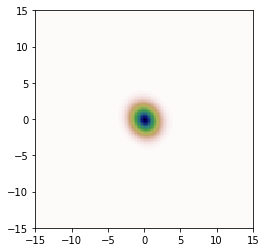

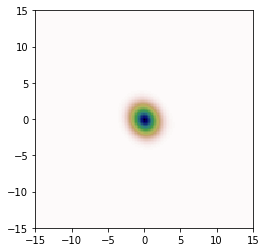

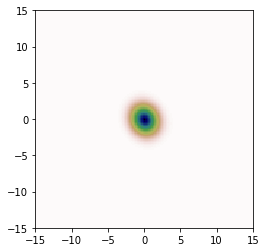

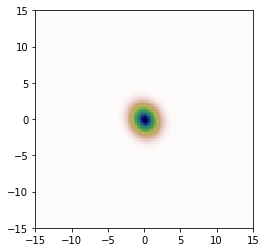

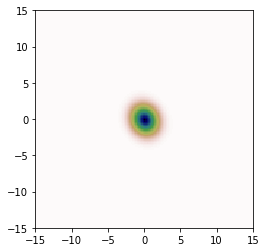

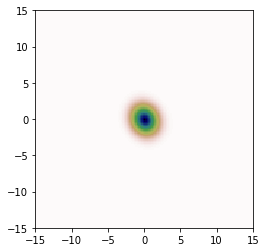

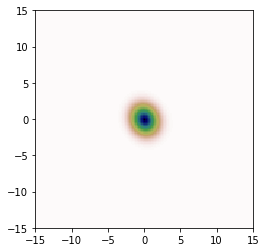

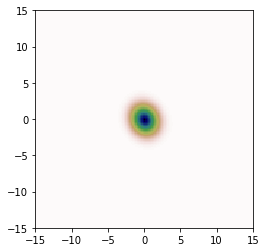

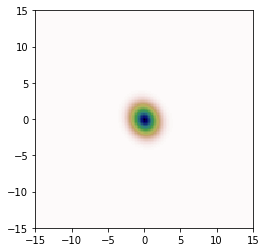

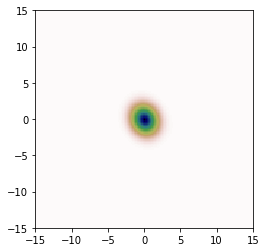

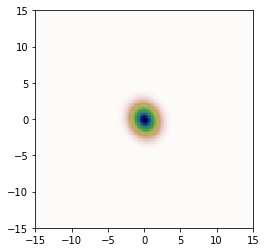

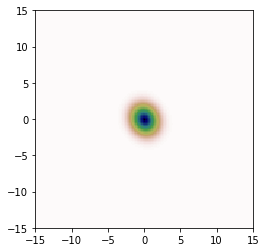

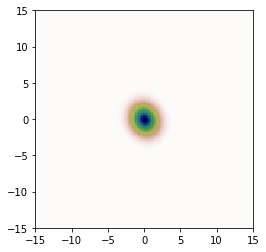

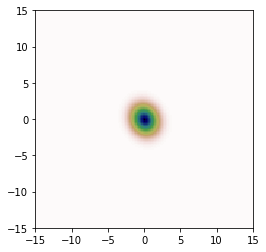

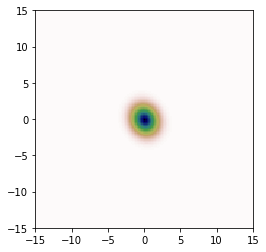

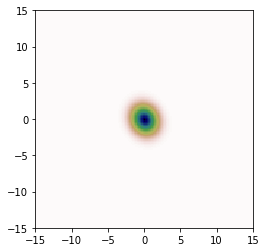

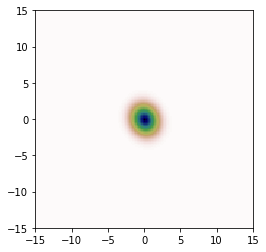

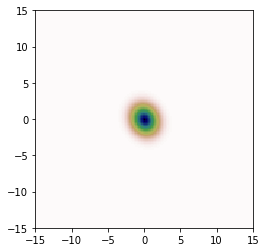

In [78]:
ani_path = create_animation_density_pictures(np.array(paths))

In [78]:
create_animation(ani_path, "test.mp4", framerate=22)

NameError: name 'ani_path' is not defined

In [24]:
np.vstack([[0, 1], [11, 100]])

array([[  0,   1],
       [ 11, 100]])

In [27]:
X, Y = np.mgrid[0:100:1, 0:100:1]
positions = np.vstack([X.ravel(), Y.ravel()])

In [28]:
positions

array([[ 0,  0,  0, ..., 99, 99, 99],
       [ 0,  1,  2, ..., 97, 98, 99]])